# Customer Churn

This notebook follows along Roman Orac's 
[article](https://towardsdatascience.com/churn-prediction-770d6cb582a5?gi=cd9302ccf89c). We create a prediction model
using **decision trees** from the [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn).


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import platform
import sklearn
import graphviz
import matplotlib
from matplotlib import style
style.use('dark_background')

## Data Preprocessing

In [3]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.dropna(how="all")   # remove samples with all missing values
df = df[~df.duplicated()]   # remove duplicates

In [4]:
total_charges_filter = (df.TotalCharges == " ")
df = df[~total_charges_filter]
df.TotalCharges = pd.to_numeric(df.TotalCharges)

In [5]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


## Data Analysis

In [6]:
categorical_features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]
numerical_features = [
    "tenure", 
    "MonthlyCharges", 
    "TotalCharges"
]
target = "Churn"

In [7]:
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>],
       [<AxesSubplot:title={'center':'TotalCharges'}>, <AxesSubplot:>]],
      dtype=object)

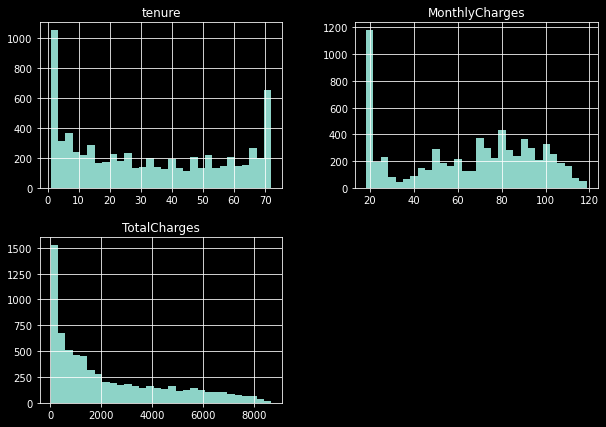

In [8]:
df[numerical_features].hist(bins=30, figsize=(10, 7))

array([<AxesSubplot:title={'center':'tenure'}>,
       <AxesSubplot:title={'center':'MonthlyCharges'}>,
       <AxesSubplot:title={'center':'TotalCharges'}>], dtype=object)

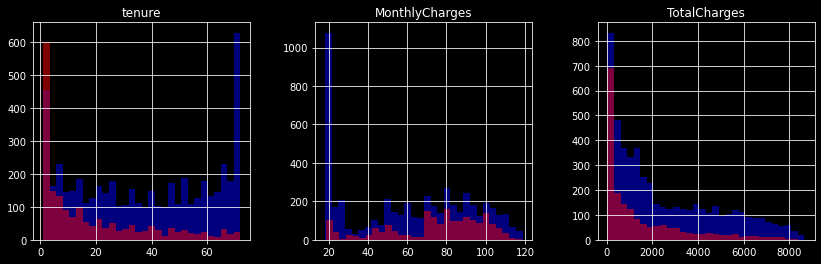

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

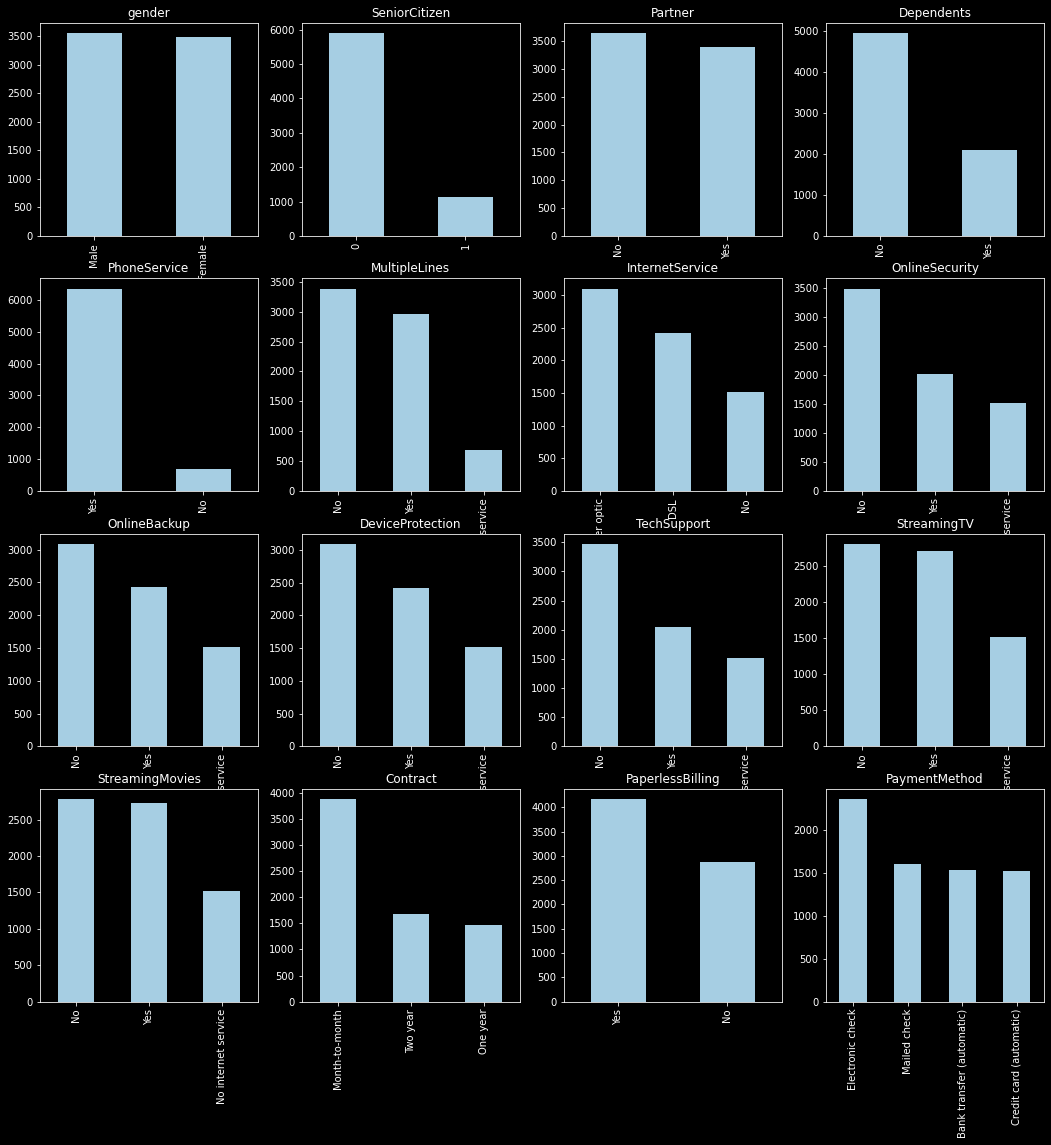

In [10]:
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot(kind='bar', ax=ax[row, col], colormap='Paired').set_title(categorical_feature)

### Comparisons with Target Variable in Mind

Text(0.5, 1.0, 'churned')

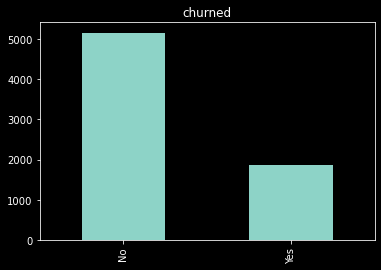

In [11]:
df[target].value_counts().plot(kind='bar').set_title('churned')

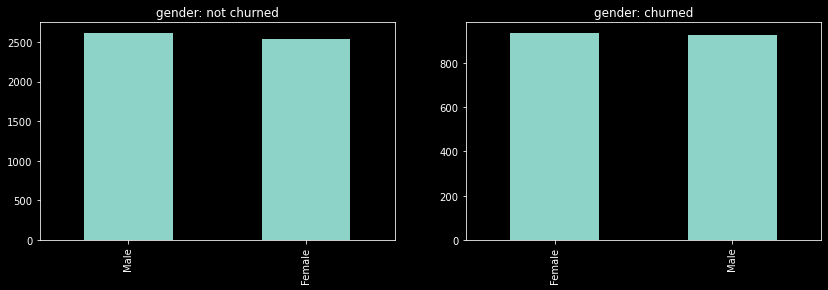

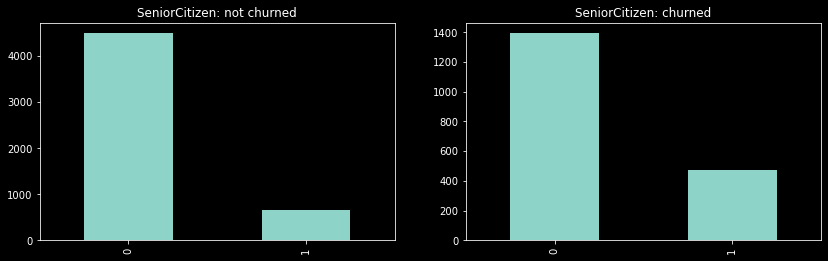

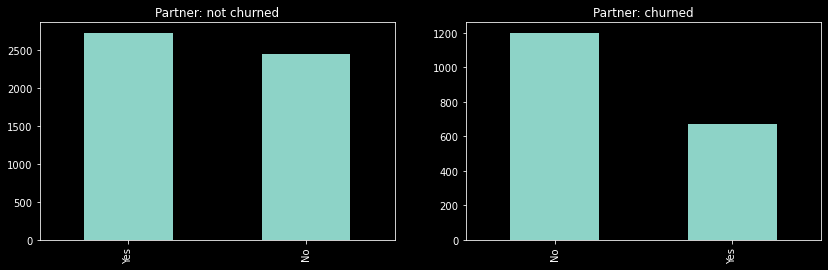

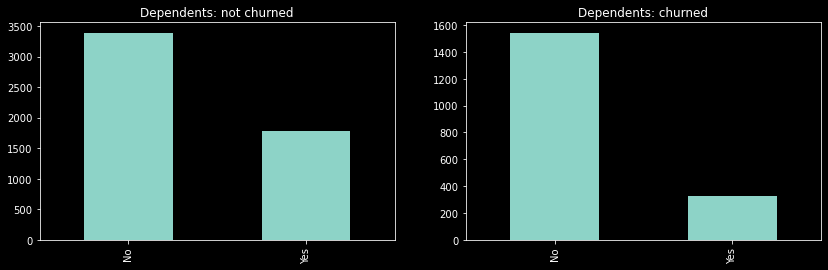

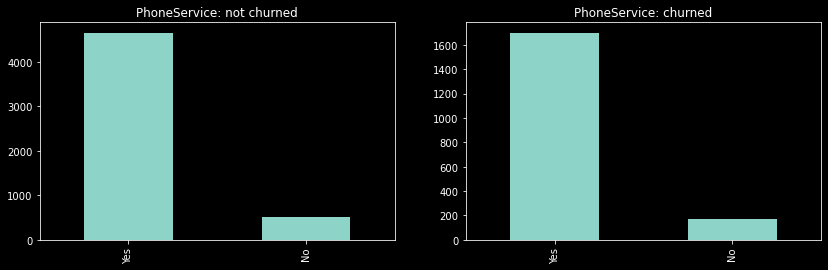

In [12]:
for feature in categorical_features[:5]:
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ctitle = feature + ": churned"
    nctitle = feature + ": not churned"
    df[df.Churn == "No"][feature].value_counts().plot(kind='bar', ax=ax[0]).set_title(nctitle)
    df[df.Churn == "Yes"][feature].value_counts().plot(kind='bar', ax=ax[1]).set_title(ctitle)

In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<!-- Implementation of one hot encoding. The article does not actually apply one hot encoding, even though it says it 
     does. For this dataset and goal, I do believe that integer encoding works just as well. -->

<!-- for feature in categorical_features+[target]:
    temp = pd.get_dummies(df[feature],prefix=feature,drop_first=False)
    i = df.columns.get_loc(feature)
    df = pd.concat([df,temp],axis=1,copy=True)
    df.drop(feature, 1, inplace=True) -->

In [14]:
from sklearn.preprocessing import LabelEncoder
categorical_feature_names = []
label_encoders = {}
for categorical in categorical_features + [target]:
    label_encoders[categorical] = LabelEncoder()    
    df[categorical] = label_encoders[categorical].fit_transform(df[categorical])
    names = label_encoders[categorical].classes_.tolist()
    print('Label encoder %s - values: %s' % (categorical, names))
    if categorical == target:
        continue
    categorical_feature_names.extend([categorical + '_' + str(name) for name in names])

Label encoder gender - values: ['Female', 'Male']
Label encoder SeniorCitizen - values: [0, 1]
Label encoder Partner - values: ['No', 'Yes']
Label encoder Dependents - values: ['No', 'Yes']
Label encoder PhoneService - values: ['No', 'Yes']
Label encoder MultipleLines - values: ['No', 'No phone service', 'Yes']
Label encoder InternetService - values: ['DSL', 'Fiber optic', 'No']
Label encoder OnlineSecurity - values: ['No', 'No internet service', 'Yes']
Label encoder OnlineBackup - values: ['No', 'No internet service', 'Yes']
Label encoder DeviceProtection - values: ['No', 'No internet service', 'Yes']
Label encoder TechSupport - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingTV - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingMovies - values: ['No', 'No internet service', 'Yes']
Label encoder Contract - values: ['Month-to-month', 'One year', 'Two year']
Label encoder PaperlessBilling - values: ['No', 'Yes']
Label encoder PaymentMethod - values

In [15]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


## Creating the Classifier

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

In [17]:
pipeline = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                transformer_list=[
                    (
                        "categorical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=categorical_features)),
                                ("onehot", OneHotEncoder()),
                            ]
                        ),
                    )
                ]
                + [
                    (
                        "numerical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=numerical_features)),
                                ("scalar", StandardScaler()),
                            ]
                        ),
                    )
                ]
            ),
        ),
        ("classifier", tree.DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]
)

## Training the Model

In [18]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

pipeline.fit(df_train, df_train[target])
pred = pipeline.predict(df_test)

## Testing the Model

In [19]:
from sklearn.metrics import classification_report

print(classification_report(df_test[target], pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1300
           1       0.67      0.37      0.48       458

    accuracy                           0.79      1758
   macro avg       0.74      0.65      0.67      1758
weighted avg       0.77      0.79      0.77      1758



## Interpreting Results

In [23]:
dot_data = tree.export_graphviz(pipeline.named_steps['classifier'], out_file=None, 
                         feature_names = categorical_feature_names + numerical_features,
                         class_names=[str(el) for el in pipeline.named_steps.classifier.classes_],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
# graph
# I exclude the above as I cannot get graphviz to work on my machine

![graph](data/graph.png)